<a href="https://colab.research.google.com/github/Inzamam1234/Network_Intrusion_Detection_CNN-LSTM/blob/main/NIDS_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install pandas numpy scikit-learn tensorflow keras matplotlib seaborn imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTETomek
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# =====================================================
# FOCAL LOSS - Focuses on hard-to-classify examples
# =====================================================
import tensorflow.keras.backend as K # Explicitly import K here

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=-1)
    return focal_loss_fixed

In [ ]:
# =====================================================
# WEIGHTED CATEGORICAL CROSSENTROPY
# =====================================================
import tensorflow.keras.backend as K # Explicitly import K here

def weighted_categorical_crossentropy(weights):
    weights = K.variable(weights)
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    return loss

In [ ]:
# Column names for NSL-KDD
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
           'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
           'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
           'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
           'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
           'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
           'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
           'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
           'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
           'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty']

In [ ]:
import pandas as pd
# Load datasets
train_df = pd.read_csv('KDDTrain+_2.csv', names=columns)
test_df = pd.read_csv('KDDTest+_2.csv', names=columns)

print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")
print(f"\nAttack distribution:\n{train_df['label'].value_counts()}")

Training samples: 125973
Testing samples: 22544

Attack distribution:
label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64


In [ ]:
# Map attacks to categories
attack_mapping = {
    'normal': 'Normal',
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS',
    'teardrop': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS', 'processtable': 'DoS',
    'udpstorm': 'DoS',
    'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'satan': 'Probe',
    'mscan': 'Probe', 'saint': 'Probe',
    'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'multihop': 'R2L',
    'phf': 'R2L', 'spy': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L',
    'sendmail': 'R2L', 'named': 'R2L', 'snmpgetattack': 'R2L', 'snmpguess': 'R2L',
    'xlock': 'R2L', 'xsnoop': 'R2L', 'worm': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R',
    'httptunnel': 'U2R', 'ps': 'U2R', 'sqlattack': 'U2R', 'xterm': 'U2R'
}

train_df['attack_category'] = train_df['label'].map(attack_mapping)
test_df['attack_category'] = test_df['label'].map(attack_mapping)

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight
# Correct import for SMOTETomek
from imblearn.combine import SMOTETomek
# Import the base SMOTE class
from imblearn.over_sampling import SMOTE, BorderlineSMOTE # Import BorderlineSMOTE if needed
from tensorflow.keras.utils import to_categorical

# Preprocess data
# Drop the 'difficulty' column as it contains NaN values
train_processed = train_df.drop('difficulty', axis=1)
test_processed = test_df.drop('difficulty', axis=1)

# Separate features and labels
X_train = train_processed.drop(['label', 'attack_category'], axis=1)
y_train_cat_label = train_processed['attack_category'] # Use the attack category for encoding

X_test = test_processed.drop(['label', 'attack_category'], axis=1)
y_test_cat_label = test_processed['attack_category'] # Use the attack category for encoding


# Encode categorical features and attack category labels
# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Apply Label Encoding to categorical features and store encoders
le_protocol = LabelEncoder()
X_train['protocol_type'] = le_protocol.fit_transform(X_train['protocol_type'])
X_test['protocol_type'] = le_protocol.transform(X_test['protocol_type'])

le_service = LabelEncoder()
X_train['service'] = le_service.fit_transform(X_train['service'])
X_test['service'] = le_service.transform(X_test['service'])

le_flag = LabelEncoder()
X_train['flag'] = le_flag.fit_transform(X_train['flag'])
X_test['flag'] = le_flag.transform(X_test['flag'])


# Encode the attack categories
le_attack = LabelEncoder()
y_train = le_attack.fit_transform(y_train_cat_label)
y_test = le_attack.transform(y_test_cat_label)


# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Display class distribution
print("\n=== Class Distribution Before Sampling ===")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(le_attack.classes_[unique], counts):
    print(f"{cls}: {count} samples")

# =====================================================
# ADVANCED OVERSAMPLING - SMOTETomek
# =====================================================
print("\n=== Applying SMOTETomek (SMOTE + Tomek Links) ===")
smotetomek = SMOTETomek(
    smote=SMOTE(random_state=42, k_neighbors=5), # Use SMOTE instead of BorderlineSMOTE
    random_state=42
)

X_train_resampled, y_train_resampled = smotetomek.fit_resample(X_train, y_train)

print("\n=== Class Distribution After Sampling ===")
unique, counts = np.unique(y_train_resampled, return_counts=True)
for cls, count in zip(le_attack.classes_[unique], counts):
    print(f"{cls}: {count} samples")

# One-hot encode labels
y_train_cat = to_categorical(y_train_resampled)
y_test_cat = to_categorical(y_test)

n_classes = len(le_attack.classes_)
print(f"\nClasses: {le_attack.classes_}")
print(f"Number of classes: {n_classes}")
print(f"Original training shape: {X_train.shape}")
print(f"Resampled training shape: {X_train_resampled.shape}")

# =====================================================
# COMPUTE CLASS WEIGHTS
# =====================================================
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)
class_weights_dict = dict(enumerate(class_weights_array))
print(f"\nClass weights: {class_weights_dict}")

# For weighted loss function
weights = np.ones(n_classes)
for i, w in class_weights_dict.items():
    weights[i] = w


=== Class Distribution Before Sampling ===
DoS: 45927 samples
Normal: 67343 samples
Probe: 11656 samples
R2L: 995 samples
U2R: 52 samples

=== Applying SMOTETomek (SMOTE + Tomek Links) ===

=== Class Distribution After Sampling ===
DoS: 67331 samples
Normal: 67317 samples
Probe: 67337 samples
R2L: 67337 samples
U2R: 67341 samples

Classes: ['DoS' 'Normal' 'Probe' 'R2L' 'U2R']
Number of classes: 5
Original training shape: (125973, 41)
Resampled training shape: (336663, 41)

Class weights: {0: np.float64(1.0000237631997149), 1: np.float64(1.0002317393823255), 2: np.float64(0.9999346570236274), 3: np.float64(0.9999346570236274), 4: np.float64(0.9998752617276251)}


In [ ]:
# =====================================================
# IMPROVED CNN MODEL with Attention
# =====================================================
from tensorflow.keras import layers, models, callbacks # Explicitly import layers here
import tensorflow.keras as keras # Explicitly import keras here


def build_improved_cnn_model(input_shape, n_classes):
    inputs = layers.Input(shape=(input_shape,))
    x = layers.Reshape((input_shape, 1))(inputs)

    # First Conv Block
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.4)(x)

    # Second Conv Block
    x = layers.Conv1D(256, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.4)(x)

    # Third Conv Block
    x = layers.Conv1D(512, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Attention Mechanism
    attention = layers.Dense(1, activation='tanh')(x)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(512)(attention)
    attention = layers.Permute([2, 1])(attention)

    x = layers.multiply([x, attention])
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# =====================================================
# IMPROVED LSTM MODEL with Bidirectional layers
# =====================================================
import tensorflow.keras as keras # Explicitly import keras here

def build_improved_lstm_model(input_shape, n_classes):
    inputs = layers.Input(shape=(input_shape,))
    x = layers.Reshape((input_shape, 1))(inputs)

    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=False))(x)
    x = layers.Dropout(0.4)(x)

    # Dense layers
    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# CALLBACKS
# =====================================================
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
from tensorflow.keras import callbacks

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [ ]:
# =====================================================
# TRAIN CNN MODEL with Focal Loss
# =====================================================
print("\n=== Training Improved CNN Model with Focal Loss ===")
cnn_model = build_improved_cnn_model(X_train_resampled.shape[1], n_classes)
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)
cnn_model.summary()

cnn_history = cnn_model.fit(
    X_train_resampled, y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


=== Training Improved CNN Model with Focal Loss ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 41)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 41, 1)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 41, 128)   │        512 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 41, 128)   │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 20, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20, 128)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 20, 256)   │     98,560 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 256)   │      1,024 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 10, 256)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 256)   │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 10, 512)   │    393,728 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 512)   │      2,048 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 1)     │        513 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 10)        │          0 │ flatten[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 512, 10)   │          0 │ activation[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 10, 512)   │          0 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 10, 512)   │          0 │ batch_normalizat… │
│                     │                   │            │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ global_average_p

 Total params: 661,766 (2.52 MB)

 Trainable params: 659,974 (2.52 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.9327 - loss: 0.0622 - val_accuracy: 6.2377e-04 - val_loss: 1.5500 - learning_rate: 0.0010
Epoch 2/50
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9757 - loss: 0.0125 - val_accuracy: 6.2377e-04 - val_loss: 1.4840 - learning_rate: 0.0010
Epoch 3/50
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9793 - loss: 0.0109 - val_accuracy: 6.2377e-04 - val_loss: 1.4521 - learning_rate: 0.0010
Epoch 4/50
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9811 - loss: 0.0099 - val_accuracy: 6.2377e-04 - val_loss: 1.4660 - learning_rate: 0.0010
Epoch 5/50
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9821 - loss: 0.0096 - val_accuracy: 6.2377e-04 - val_loss: 1.4597 - learning_rate: 0.0010
Epoch 6/50
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9839 - loss: 0.0088 - val_accuracy: 6.2377e-04 - val_loss: 1.4168 - learning_rate: 0.0010
Epoch 7/50
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 

In [ ]:
# =====================================================
# TRAIN LSTM MODEL with Weighted Loss
# =====================================================
print("\n=== Training Improved LSTM Model with Weighted Loss ===")
lstm_model = build_improved_lstm_model(X_train_resampled.shape[1], n_classes)
lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=weighted_categorical_crossentropy(weights),
    metrics=['accuracy']
)
lstm_model.summary()

lstm_history = lstm_model.fit(
    X_train_resampled, y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


=== Training Improved LSTM Model with Weighted Loss ===


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 41)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 41, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 41, 256)        │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 41, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 41, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,869 (1.48 MB)

 Trainable params: 388,869 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 99s 21ms/step - accuracy: 0.9164 - loss: 0.3412 - val_accuracy: 6.0891e-04 - val_loss: 9.0068 - learning_rate: 0.0010
Epoch 2/50
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 89s 21ms/step - accuracy: 0.9772 - loss: 0.0956 - val_accuracy: 6.2377e-04 - val_loss: 7.9349 - learning_rate: 0.0010
Epoch 3/50
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 88s 21ms/step - accuracy: 0.9825 - loss: 0.0750 - val_accuracy: 6.0891e-04 - val_loss: 8.1754 - learning_rate: 0.0010
Epoch 4/50
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 89s 21ms/step - accuracy: 0.9852 - loss: 0.0636 - val_accuracy: 6.2377e-04 - val_loss: 7.1981 - learning_rate: 0.0010
Epoch 5/50
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 88s 21ms/step - accuracy: 0.9873 - loss: 0.0550 - val_accuracy: 6.2377e-04 - val_loss: 7.2231 - learning_rate: 0.0010
Epoch 6/50
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 143s 21ms/step - accuracy: 0.9885 - loss: 0.0497 - val_accuracy: 6.2377e-04 - val_loss: 7.1412 - learning_rate: 0.0010
Epoch 7/50
4209/4209 ━━━━━━━━━━━━━━━━━━

In [ ]:
# =====================================================
# ENSEMBLE PREDICTION with Threshold Adjustment
# =====================================================
def ensemble_predict_with_threshold(models, X, thresholds=None):
    predictions = []
    for model in models:
        pred = model.predict(X, verbose=0)
        predictions.append(pred)

    # Average predictions
    ensemble_pred = np.mean(predictions, axis=0)

    # Apply custom thresholds for rare classes if provided
    if thresholds is not None:
        for i, threshold in enumerate(thresholds):
            if threshold is not None:
                ensemble_pred[:, i] = np.where(ensemble_pred[:, i] >= threshold,
                                               ensemble_pred[:, i], 0)

    return np.argmax(ensemble_pred, axis=1)

# Custom thresholds (lower for rare classes to make them easier to predict)
custom_thresholds = [None] * n_classes
for i, cls in enumerate(le_attack.classes_):
    if cls in ['Probe', 'R2L', 'U2R']:
        custom_thresholds[i] = 0.3  # Lower threshold for rare classes
    else:
        custom_thresholds[i] = 0.5  # Normal threshold for common classes

In [ ]:
# =====================================================
# EVALUATION
# =====================================================
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

print("\n=== Evaluating CNN Model ===")
y_pred_cnn = np.argmax(cnn_model.predict(X_test, verbose=0), axis=1)
print("\nCNN Classification Report:")
print(classification_report(y_test, y_pred_cnn, target_names=le_attack.classes_, digits=4))
print(f"CNN Overall Accuracy: {accuracy_score(y_test, y_pred_cnn):.4f}")

print("\n=== Evaluating LSTM Model ===")
y_pred_lstm = np.argmax(lstm_model.predict(X_test, verbose=0), axis=1)
print("\nLSTM Classification Report:")
print(classification_report(y_test, y_pred_lstm, target_names=le_attack.classes_, digits=4))
print(f"LSTM Overall Accuracy: {accuracy_score(y_test, y_pred_lstm):.4f}")

print("\n=== Evaluating Ensemble Model ===")
y_pred_ensemble = ensemble_predict_with_threshold([cnn_model, lstm_model], X_test, custom_thresholds)
print("\nEnsemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble, target_names=le_attack.classes_, digits=4))
print(f"Ensemble Overall Accuracy: {accuracy_score(y_test, y_pred_ensemble):.4f}")


=== Evaluating CNN Model ===

CNN Classification Report:
              precision    recall  f1-score   support

         DoS     0.9609    0.7843    0.8636      7458
      Normal     0.6762    0.9681    0.7963      9711
       Probe     0.7818    0.6068    0.6833      2421
         R2L     0.9349    0.2295    0.3685      2754
         U2R     0.0000    0.0000    0.0000       200

    accuracy                         0.7697     22544
   macro avg     0.6708    0.5177    0.5423     22544
weighted avg     0.8073    0.7697    0.7471     22544

CNN Overall Accuracy: 0.7697

=== Evaluating LSTM Model ===

LSTM Classification Report:
              precision    recall  f1-score   support

         DoS     0.9538    0.7561    0.8435      7458
      Normal     0.6564    0.9765    0.7851      9711
       Probe     0.7015    0.5651    0.6259      2421
         R2L     0.9191    0.0784    0.1445      2754
         U2R     0.0000    0.0000    0.0000       200

    accuracy                         0

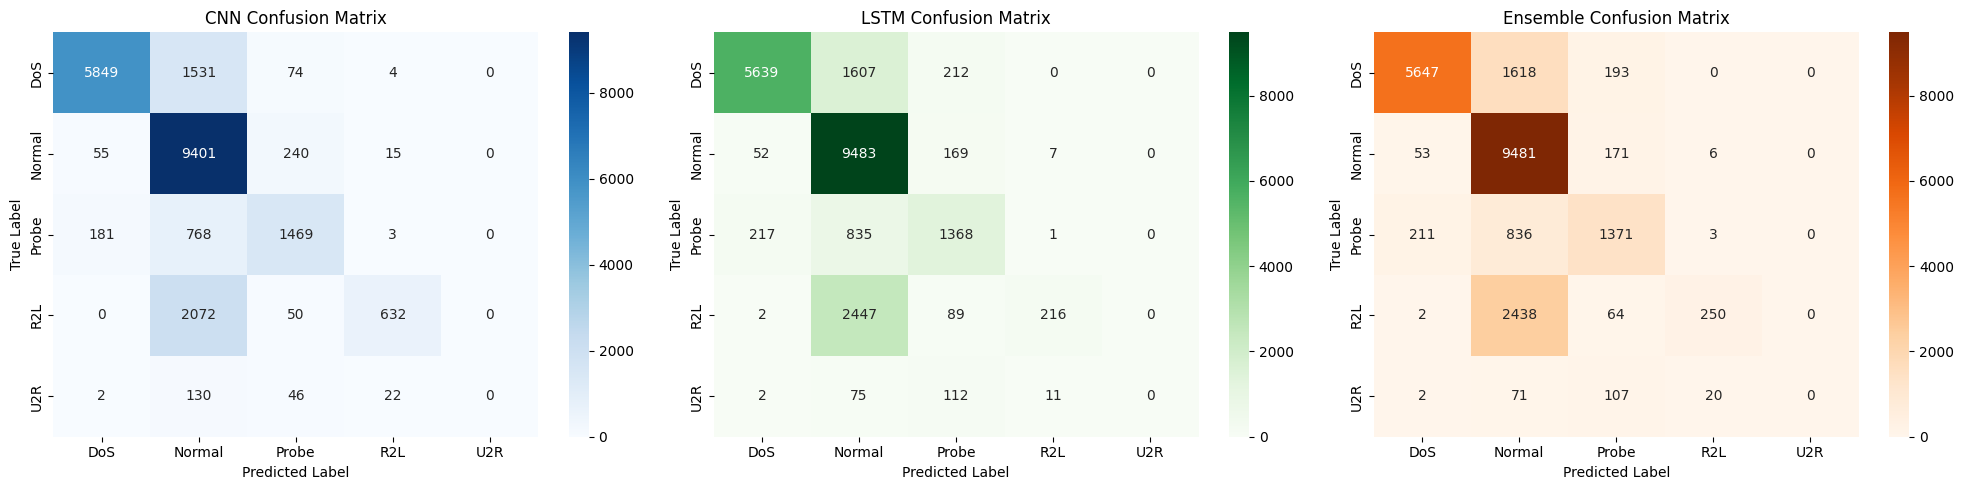

In [ ]:
# =====================================================
# CONFUSION MATRICES
# =====================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

cm_cnn = confusion_matrix(y_test, y_pred_cnn)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_attack.classes_, yticklabels=le_attack.classes_, ax=axes[0])
axes[0].set_title('CNN Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

cm_lstm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le_attack.classes_, yticklabels=le_attack.classes_, ax=axes[1])
axes[1].set_title('LSTM Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le_attack.classes_, yticklabels=le_attack.classes_, ax=axes[2])
axes[2].set_title('Ensemble Confusion Matrix')
axes[2].set_ylabel('True Label')
axes[2].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

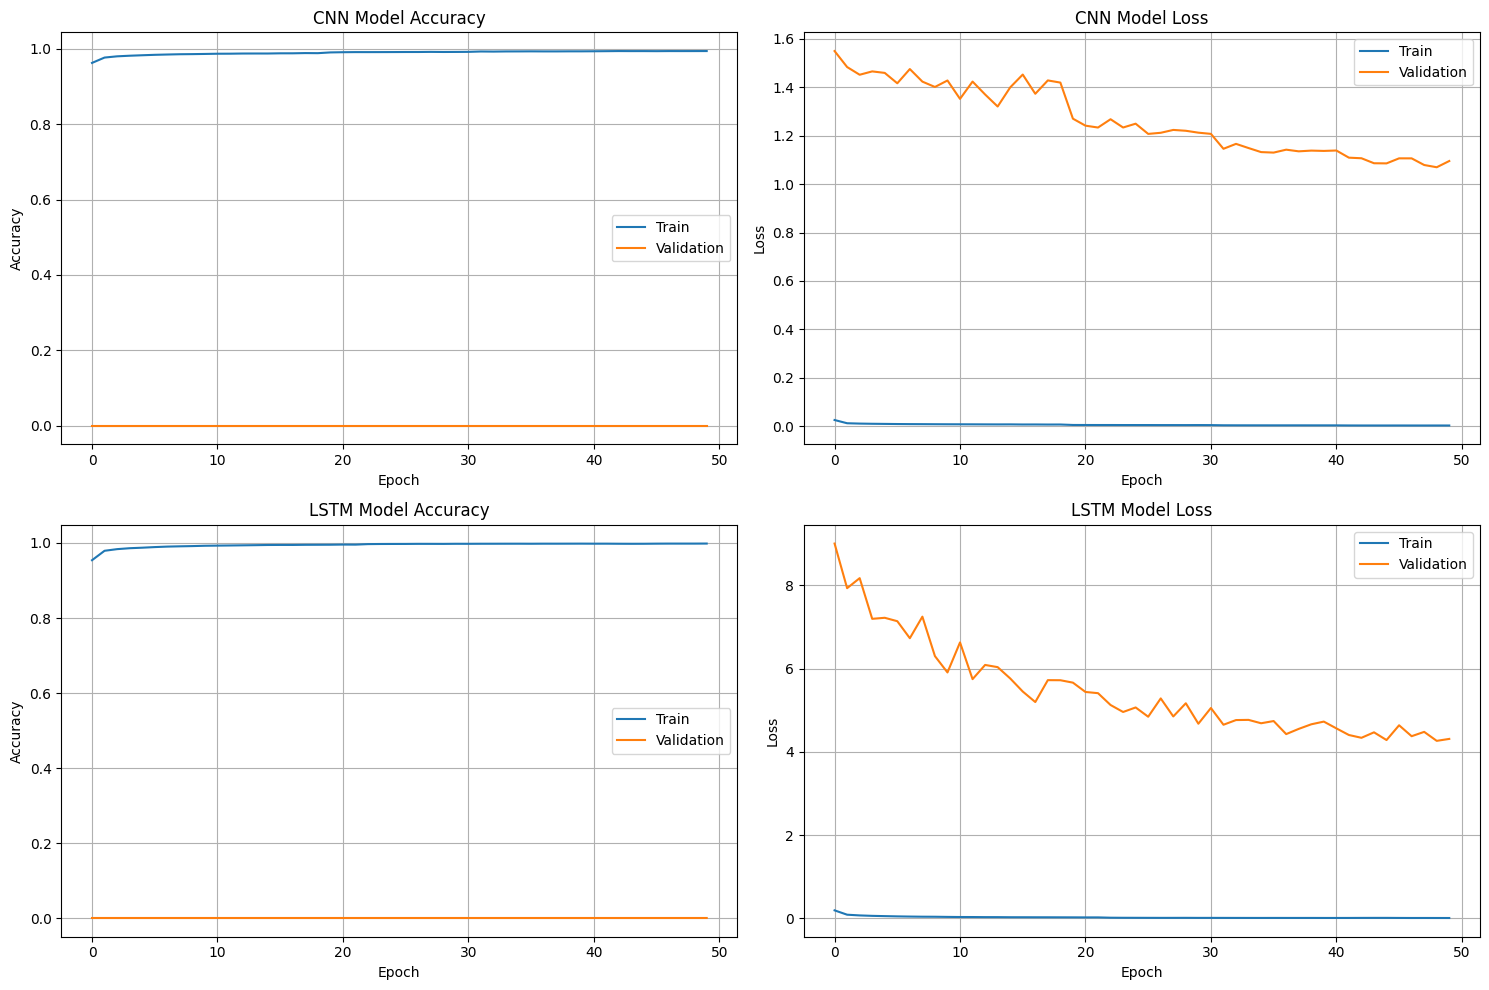

In [ ]:
# =====================================================
# TRAINING HISTORY PLOTS
# =====================================================
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(cnn_history.history['accuracy'], label='Train')
axes[0, 0].plot(cnn_history.history['val_accuracy'], label='Validation')
axes[0, 0].set_title('CNN Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(cnn_history.history['loss'], label='Train')
axes[0, 1].plot(cnn_history.history['val_loss'], label='Validation')
axes[0, 1].set_title('CNN Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(lstm_history.history['accuracy'], label='Train')
axes[1, 0].plot(lstm_history.history['val_accuracy'], label='Validation')
axes[1, 0].set_title('LSTM Model Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(lstm_history.history['loss'], label='Train')
axes[1, 1].plot(lstm_history.history['val_loss'], label='Validation')
axes[1, 1].set_title('LSTM Model Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# =====================================================
# SAVE MODELS AND PREPROCESSORS
# =====================================================
import pickle

cnn_model.save('improved_cnn_model.h5')
lstm_model.save('improved_lstm_model.h5')

with open('preprocessors.pkl', 'wb') as f:
    pickle.dump({
        'scaler': scaler,
        'le_attack': le_attack,
        'le_protocol': le_protocol,
        'le_service': le_service,
        'le_flag': le_flag
    }, f)

print("\n=== Models and preprocessors saved successfully! ===")
print("Files saved: improved_cnn_model.h5, improved_lstm_model.h5, preprocessors.pkl")


=== Models and preprocessors saved successfully! ===
Files saved: improved_cnn_model.h5, improved_lstm_model.h5, preprocessors.pkl
